In [1]:
import jax
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
from functools import partial
import sympy as sp
import scipy.stats as stats


In [2]:
key = jr.PRNGKey(4)

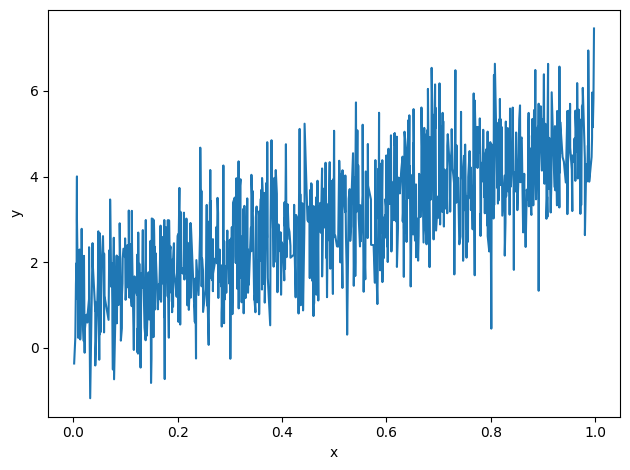

In [3]:
def generate_data(key, n_data):
    x_key, noise_key = jr.split(key)
    weight = 4.0
    bias = 1.0
    x = jr.uniform(x_key, (n_data, ))
    x = jnp.sort(x)
    noise = jr.normal(noise_key, x.shape)
    y = weight * x + bias + noise
    return x, y

n_data = 1000
x, y = generate_data(key, n_data)

plt.xlabel('x')
plt.ylabel('y')
plt.plot(x, y);
plt.tight_layout()
plt.savefig('../seminar_talk/plots/sample_data.pdf',bbox_inches='tight')

# Analysis of data

In [16]:
X = jnp.stack((x, jnp.ones_like(x))).T
jnp.linalg.eigh(X.T @ X)

(DeviceArray([  63.333252, 1263.5747  ], dtype=float32),
 DeviceArray([[-0.88340175,  0.46861652],
              [ 0.46861652,  0.88340175]], dtype=float32))

In [17]:
U, S, V = jnp.linalg.svd(X)
S

DeviceArray([35.5468   ,  7.9582157], dtype=float32)

# Gradient descent

In [6]:
key, subkey = jr.split(key)
weight, bias = jr.normal(subkey, (2,))
weight_0 = weight.copy()
bias_0 = bias.copy()

In [7]:
@jax.jit
def loss(weight, bias, x, y): return jnp.square(weight * x + bias - y).sum(0)

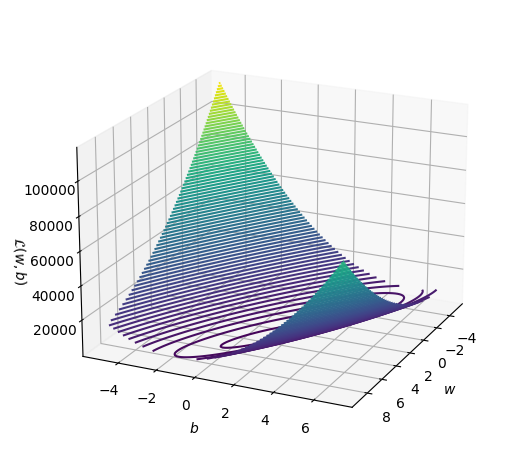

In [8]:
import numpy as np
fig = plt.figure()
ax = plt.axes(projection='3d')
fig.tight_layout()
weights_plt = np.linspace(-5, 9, 100)
biases_plt = np.linspace(-5, 7, 100)
W, B = np.meshgrid(weights_plt, biases_plt)
# L = (W * x + B - y) **
# L.shape
f = jnp.sum(((W[None,:,:] * x[:,None,None] + B[None, :, :] - y[:, None, None]) ** 2), 0)
ax.contour3D(W, B, f, 90);
ax.set_xlabel('$w$')
ax.set_ylabel('$b$')
ax.set_zlabel('$\mathcal{L} (w,b)$')
ax.view_init(20, 25)
# L
# fig.tight_layout()
plt.savefig('../seminar_talk/plots/quadratic_loss.pdf',bbox_inches='tight')

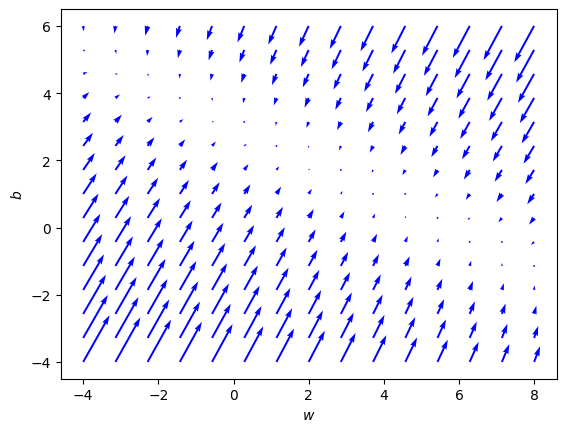

In [21]:
weights_plt = np.linspace(-4, 8, 15)
biases_plt = np.linspace(-4, 6, 15)
W, B = np.meshgrid(weights_plt, biases_plt)


def batched_loss(weight, bias, x, y): return jnp.square(
    weight * x + bias - y).sum(0)


@partial(jax.jit)
def grid_gradients(W, B, x, y):
    return jax.vmap(jax.vmap(jax.grad(
        batched_loss, argnums=(0, 1)), in_axes=(0, 0, None, None)), in_axes=(0, 0, None, None))(W, B, x, y)


dW, dB = grid_gradients(W, B, x, y)
# plt_W = np.asarray(W)
# plt_dW = np.asarray(dW)
# plt_B = np.asarray(B)
# plt_dB = np.asarray(dB)
plt.quiver(W, B, -dW, -dB, color='b')
plt.xlabel('$w$')
plt.ylabel('$b$')
# plt.show()
# plt_dB.shape
plt.savefig('../seminar_talk/plots/gradients.pdf')

Weight: 3.136, bias: 1.442
Loss: 1017.139892578125
Weight: 3.754, bias: 1.114
Loss: 985.7225341796875
Weight: 3.758, bias: 1.112
Loss: 985.7213745117188
Weight: 3.758, bias: 1.112
Loss: 985.7213745117188


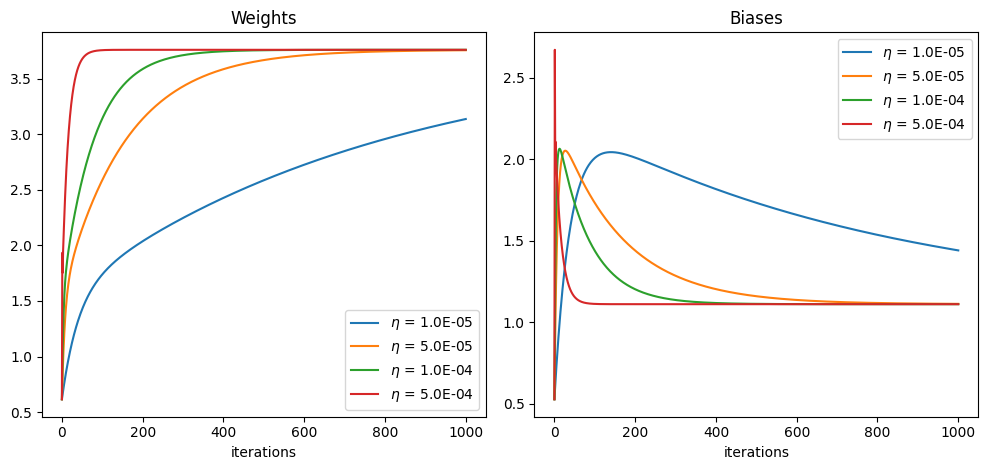

In [12]:
learning_rates = [0.00001, 0.00005, 0.0001, 0.0005]
max_iter = 1000
fig, ax = plt.subplots(1, 2)
fig.set_figwidth(10)
for learning_rate in learning_rates:
    weight = weight_0
    bias = bias_0
    weights = [weight]
    biases = [bias]
    for i in range(max_iter):
        dweight, dbias = jax.grad(loss, argnums=(0, 1))(weight, bias, x, y)
        weight += - learning_rate * dweight
        bias += - learning_rate * dbias
        weights.append(weight)
        biases.append(bias)
    weights = jnp.array(weights)
    biases = jnp.array(biases)
    print(f'Weight: {weight:.3f}, bias: {bias:.3f}')
    print(f'Loss: {loss(weight, bias, x, y)}')
    ax[0].plot(jnp.arange(0, max_iter+1), weights,
               label=f'$\eta$ = {learning_rate:.1E}')
    ax[0].set_title('Weights')
    ax[1].plot(jnp.arange(0, max_iter+1), biases,
               label=f'$\eta$ = {learning_rate:.1E}')
    ax[1].set_title('Biases')
    ax[0].set_xlabel('iterations')
    ax[1].set_xlabel('iterations')
    ax[0].legend()
    ax[1].legend()
fig.tight_layout()
plt.savefig('../seminar_talk/plots/learning_rates.pdf',bbox_inches='tight')

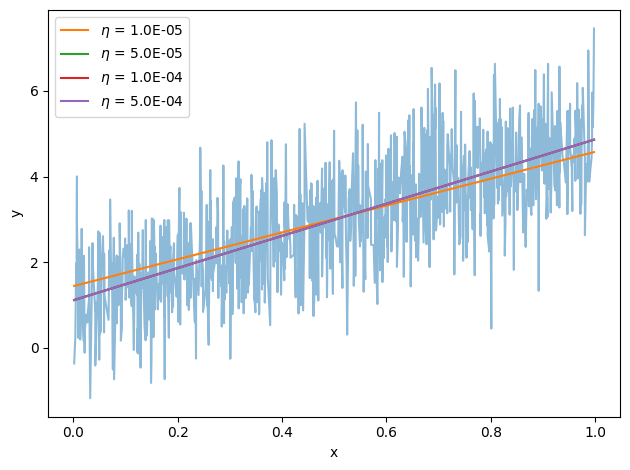

In [23]:
learning_rates = [0.00001, 0.00005, 0.0001, 0.0005]
max_iter = 1000

plt.plot(x, y, alpha = .5)
for learning_rate in learning_rates:
    weight = weight_0
    bias = bias_0
    weights = [weight]
    biases = [bias]
    for i in range(max_iter):
        dweight, dbias = jax.grad(loss, argnums=(0, 1))(weight, bias, x, y)
        weight += - learning_rate * dweight
        bias += - learning_rate * dbias
        weights.append(weight)
        biases.append(bias)
    weights = jnp.array(weights)
    biases = jnp.array(biases)

    y_hat = weight * x + bias

    plt.plot(x, y_hat, label=f'$\eta$ = {learning_rate:.1E}')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.tight_layout()
plt.savefig('../seminar_talk/plots/linear_fit.pdf',bbox_inches='tight')

Weight: nan, bias: nan
Loss: nan


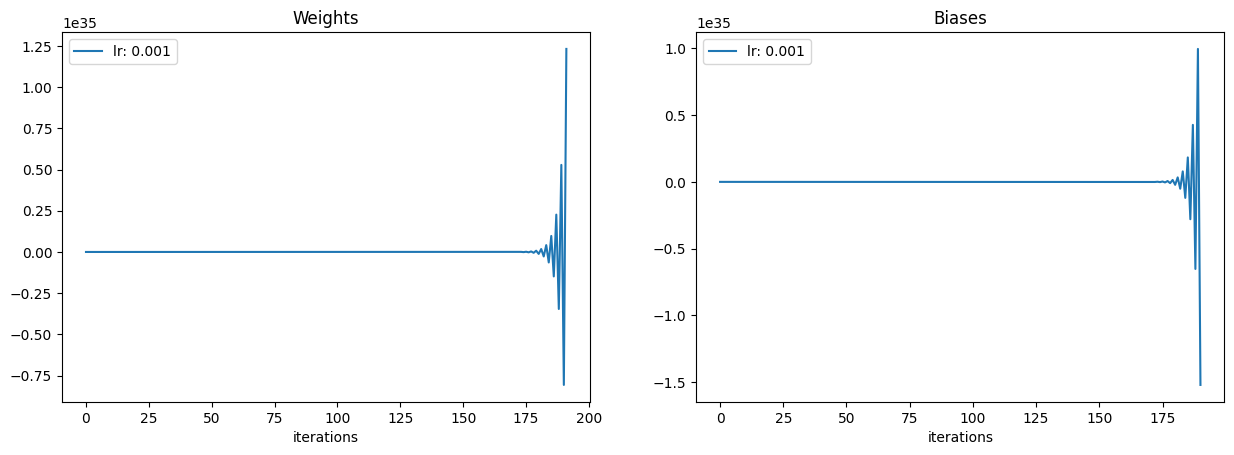

In [24]:
# Large learning rate
learning_rates = [0.001]
max_iter = 1000
fig, ax = plt.subplots(1, 2)
fig.set_figwidth(15)
for learning_rate in learning_rates:
    weight = weight_0
    bias = bias_0
    weights = [weight]
    biases = [bias]
    for i in range(max_iter):
        dweight, dbias = jax.grad(loss, argnums=(0, 1))(weight, bias, x, y)
        weight += - learning_rate * dweight
        bias += - learning_rate * dbias
        weights.append(weight)
        biases.append(bias)
    weights = jnp.array(weights)
    biases = jnp.array(biases)
    print(f'Weight: {weight:.3f}, bias: {bias:.3f}')
    print(f'Loss: {loss(weight, bias, x, y)}')
    ax[0].plot(jnp.arange(0, max_iter+1), weights,
               label=f'lr: {learning_rate}')
    ax[0].set_title('Weights')
    ax[1].plot(jnp.arange(0, max_iter+1), biases,
               label=f'lr: {learning_rate}')
    ax[1].set_title('Biases')
    ax[0].set_xlabel('iterations')
    ax[1].set_xlabel('iterations')
    ax[0].legend()
    ax[1].legend()
plt.savefig('../seminar_talk/plots/large_learning_rate.pdf')


Weight: 3.136, bias: 1.442
Loss: 1017.139892578125
Weight: 3.754, bias: 1.114
Loss: 985.7225341796875
Weight: 3.758, bias: 1.112
Loss: 985.7213745117188
Weight: 3.758, bias: 1.112
Loss: 985.7213745117188


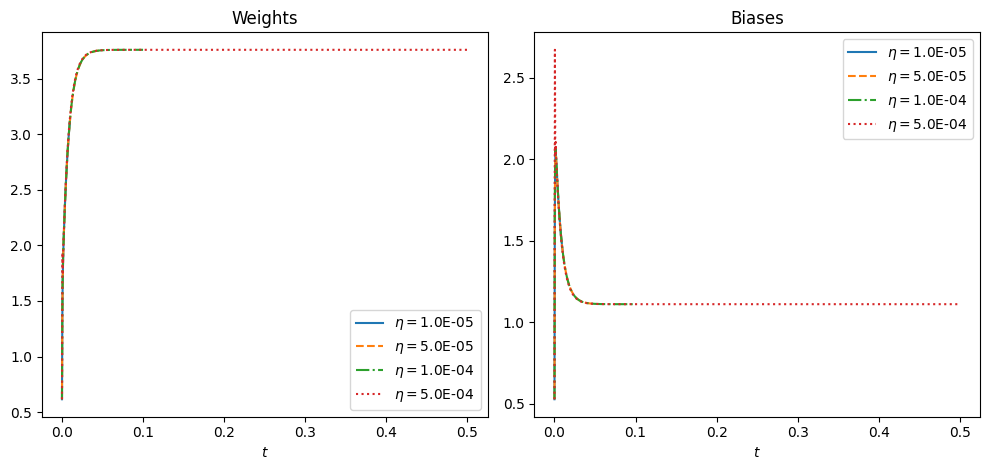

In [25]:
# Scaled learning rates
learning_rates = [0.00001, 0.00005, 0.0001, 0.0005]
line_styles = ['-', '--', '-.', ':']
max_iter = 1000
fig, ax = plt.subplots(1, 2)
fig.set_figwidth(10)
for line_style, learning_rate in zip(line_styles, learning_rates):
    weight = weight_0
    bias = bias_0
    weights = [weight]
    biases = [bias]
    for i in range(max_iter):
        dweight, dbias = jax.grad(loss, argnums=(0, 1))(weight, bias, x, y)
        weight += - learning_rate * dweight
        bias += - learning_rate * dbias
        weights.append(weight)
        biases.append(bias)
    weights = jnp.array(weights)
    biases = jnp.array(biases)
    print(f'Weight: {weight:.3f}, bias: {bias:.3f}')
    print(f'Loss: {loss(weight, bias, x, y)}')
    t = jnp.linspace(0, max_iter * learning_rate, max_iter + 1)
    ax[0].plot(t, weights, line_style,
               label=f'$\eta=${learning_rate:.1E}')
    ax[0].set_title('Weights')
    ax[1].plot(t, biases, line_style,
               label=f'$\eta=${learning_rate:.1E}')
    ax[1].set_title('Biases')
    ax[0].set_xlabel('$t$')
    ax[1].set_xlabel('$t$')
    ax[0].legend()
    ax[1].legend()
fig.tight_layout()
plt.savefig('../seminar_talk/plots/scaled_weights_biases.pdf',
            bbox_inches='tight')


# Observations

The parameters follow a smooth trajectory.
Update rule: $X_{k+1} = X_k - \eta \nabla f(X_k), \quad X_0 = x$.

This is Euler's method for the system of ODEs: $X'(t) = - \nabla f(X(t)), \quad X(0) = x$.

In the above example we have: $$f(w, b) = \sum_{i=1}^n (w x_i + b - y_i)^2$$.
$$\nabla_w f(w,b) = \sum_{i=1}^n 2 (w x_i + b - y_i) x_i = 2\left(\sum_{i=1}^n x_i^2 \right) w + 2\left(\sum_{i=1}^n x_i \right) b - 2 \sum_{i=1}^n x_i y_i$$
$$\nabla_b f(w,b) = \sum_{i=1}^n 2 (w x_i + b - y_i) = 2\left(\sum_{i=1}^n x_i \right) w + 2 n b - 2 \sum_{i=1}^n y_i$$


In [26]:
# Analytical solution of the ODE system
x_sum_squared = float((x ** 2).sum())
x_sum = float((x).sum())
x_y_sum = float((x * y).sum())
y_sum = float((y).sum())

w_0 = float(weight_0)
b_0 = float(bias_0)

t = sp.symbols('t')
w = sp.Function('w')
b = sp.Function('b')
solution = sp.dsolve([w(t).diff(t) + 2 * x_sum_squared * w(t) + 2 * x_sum * b(t) - 2 *
                      x_y_sum, b(t).diff(t) + 2 * x_sum * w(t) + 2 * n_data * b(t) - 2 * y_sum], ics={w(0): w_0, b(0): b_0})
solution

[Eq(w(t), 3.75801825483611 - 0.931281155583232*exp(-2527.149913078*t) - 2.20998679932231*exp(-126.666371101683*t)),
 Eq(b(t), 1.11158383898243 - 1.75558277134754*exp(-2527.149913078*t) + 1.17232812595718*exp(-126.666371101683*t))]

In [27]:
w_t = sp.lambdify([t], solution[0].rhs)
b_t = sp.lambdify([t], solution[1].rhs)
w_t(0), w_0, b_t(0), b_0

(0.6167502999305681, 0.6167502999305725, 0.52832919359207, 0.5283291935920715)

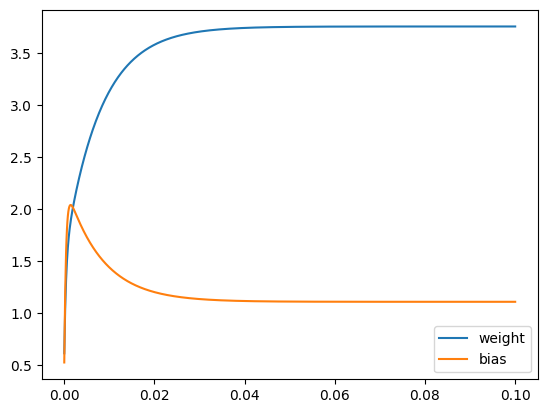

In [28]:
learning_rate = 0.0001
t = jnp.linspace(0, max_iter * learning_rate, max_iter)
plt.plot(t, w_t(t), label = 'weight')
plt.plot(t, b_t(t), label='bias')
plt.legend();

In [29]:
# SGD
@jax.jit
@partial(jax.vmap, in_axes=(0, 0, 0, 0, None))
def update(weight, bias, x_batch, y_batch, learning_rate):
    value, (dweight, dbias) = jax.value_and_grad(loss, argnums=(0, 1))(
        weight, bias, x_batch, y_batch)
    weight += - learning_rate * dweight
    bias += - learning_rate * dbias
    return value, weight, bias


def sgd_run(key, learning_rate, batch_size, max_iter):
    repetitions = 10000
    
    weight = jnp.repeat(weight_0[None, None], repetitions, axis=0)
    bias = jnp.repeat(bias_0[None, None], repetitions, axis=0)
    weights = [weight]
    biases = [bias]
    values = []
    for i in range(max_iter):
        key, sample_key = jr.split(key)
        ix = jr.choice(sample_key, jnp.arange(
            0, x.shape[0]), (repetitions, batch_size))
        value, weight, bias = update(weight, bias, x[ix], y[ix], learning_rate)
        weights.append(weight)
        biases.append(bias)
        values.append(value)
    return jnp.array(values), jnp.array(weights).squeeze(), jnp.array(biases).squeeze()

max_iter = 1000
learning_rate = 0.1
batch_size = 1
values, weights, biases = sgd_run(key, learning_rate, batch_size, max_iter)

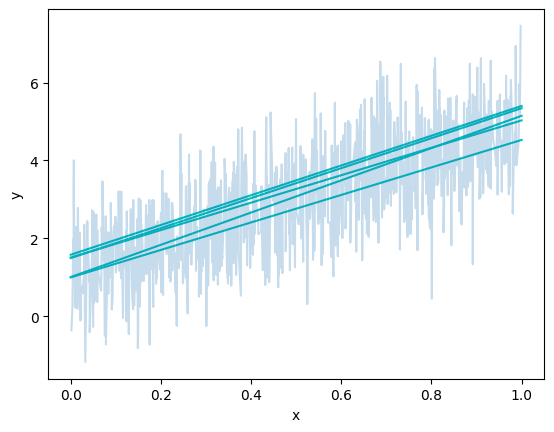

In [30]:
x_plt = jnp.linspace(0,1,100)
y_hat = weights[-1,:]* x_plt[:, None] + biases[-1,:]
for i in range(0,y_hat.shape[1],2000):
    plt.plot(x_plt, y_hat[:,i], 'c')
plt.plot(x,y,alpha=0.25)
plt.xlabel('x')
plt.ylabel('y')
plt.savefig('../seminar_talk/plots/sgd_linear_fit.pdf')

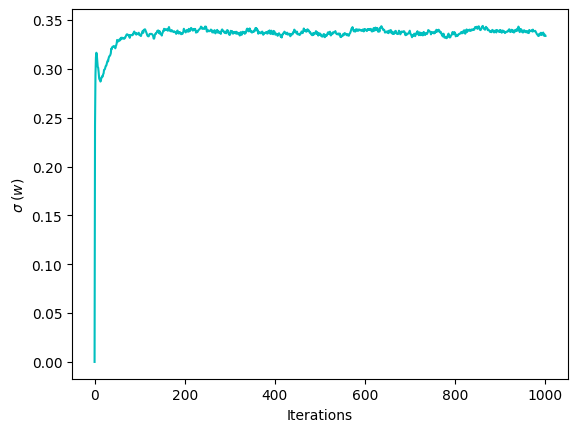

In [31]:
std = jnp.std(weights, 1)
plt.plot(std, 'c')
plt.xlabel('Iterations')
plt.ylabel('$\sigma\;(w)$')
plt.savefig('../seminar_talk/plots/sgd_std.pdf')

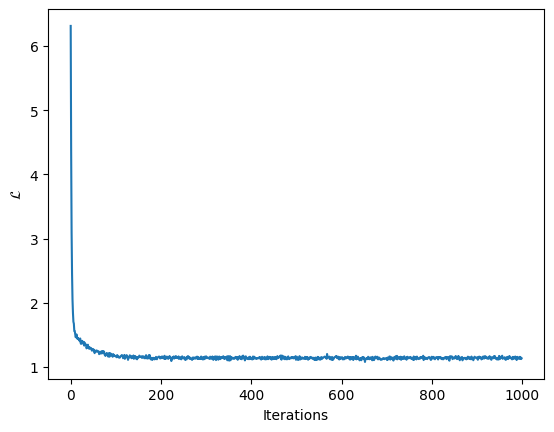

In [32]:
plt.plot(values.mean(1))
plt.xlabel('Iterations')
plt.ylabel('$\mathcal{L}$');

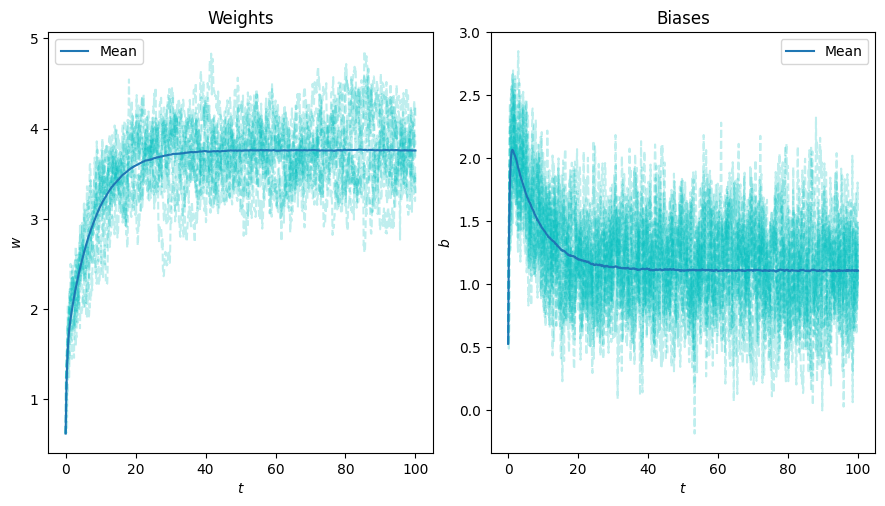

In [37]:
fig, axes = plt.subplots(1, 2)
fig.set_figwidth(9)
fig.tight_layout()
t = jnp.linspace(0, max_iter * learning_rate,
                 max_iter+1)
for i in range(0, weights.shape[1],1000):
    axes[0].plot(t, weights[:, i], 'c--', alpha=0.25)
    axes[1].plot(t, biases[:, i], 'c--', alpha=0.25)
axes[0].plot(jnp.linspace(0, max_iter * learning_rate, max_iter+1),
             weights[:, :].mean(1), label='Mean')
axes[1].plot(jnp.linspace(0, max_iter * learning_rate, max_iter+1),
             biases[:, :].mean(1), label='Mean')
# axes[0].plot(t, jnp.ones_like(t) * 4.0, 'm', label='Optimal $w$')
# axes[1].plot(t, jnp.ones_like(t) * 1.0, 'm', label='Optimal $b$')
axes[0].set_title('Weights')
axes[1].set_title('Biases')
axes[0].set_ylabel('$w$')
axes[1].set_ylabel('$b$')
for axis in axes:
    axis.set_xlabel('$t$')
axes[0].legend();
axes[1].legend();
plt.savefig('../seminar_talk/plots/sgd_weight_bias.pdf')

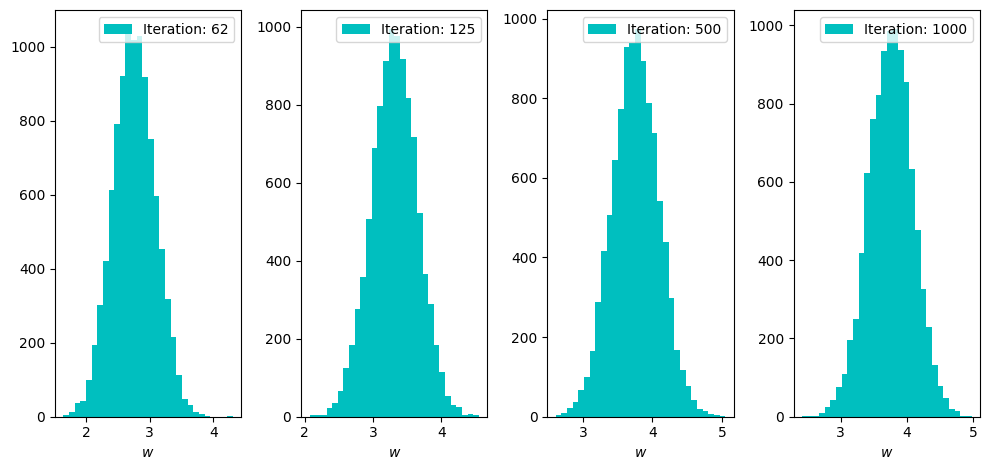

In [34]:
max_iter = 1000
learning_rate = 0.1
batch_size = 1
fig, axes = plt.subplots(1, 4)
fig.set_figwidth(10)
iterations = [max_iter // 16, max_iter // 8, max_iter // 2, max_iter]
_, weights, biases = sgd_run(key, learning_rate, batch_size, max_iter)
for i, iteration in enumerate(iterations):
    axes[i].hist(weights[iteration, :], 30, color='c',
                 label=f'Iteration: {iteration}')
    axes[i].set_xlabel('$w$')
    axes[i].legend()
fig.tight_layout()
plt.savefig('../seminar_talk/plots/sgd_weight_histogram.pdf',
            bbox_inches='tight')


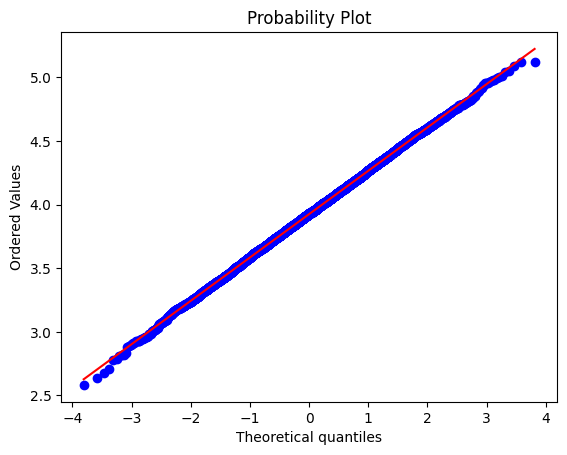

In [111]:
measurements = weights[-1,:]
stats.probplot(measurements, dist="norm", plot=plt);
plt.savefig('../seminar_talk/plots/sgd_weight_qq.pdf')
